# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [45]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import matplotlib.pyplot as plt
import pickle as pkl
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

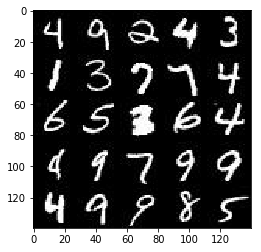

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

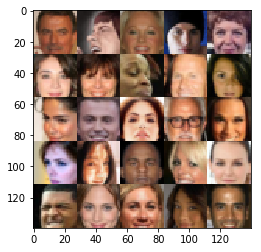

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [56]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(dtype = tf.float32,shape = [None, image_width,image_height,image_channels], name = 'real_input')
    z_input = tf.placeholder(dtype = tf.float32,shape = [None, z_dim], name = 'z_input')
    learning_rate = tf.placeholder(dtype = tf.float32,name = 'learning')
    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [138]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator',reuse = reuse):
        # conv2d layer 1 input 28x28x3
        conv1 = tf.layers.conv2d(images,64,5,strides=2,padding='same')
        relu1 = tf.maximum(0.2*conv1,conv1)
        # 14x14x64
        
        # conv2d layer 2 
        conv2 = tf.layers.conv2d(relu1,128,5,strides=2,padding='same')
        bn2 = tf.layers.batch_normalization(conv2, training=True)
        relu2 = tf.maximum(0.2*bn2,bn2)
        # 7x7x128
        
        # conv2d layer 3
        conv3 = tf.layers.conv2d(relu2, 256, 5, strides = 2, padding='same')
        bn3 = tf.layers.batch_normalization(conv3, training=True)
        relu3 = tf.maximum(0.2*bn3,bn3)
        # 4x4x256
        
        # fully connected layer
        logits = tf.layers.dense(tf.reshape(relu3,[-1,4*4*256]),1)
        output = tf.sigmoid(logits)
    
    return output,logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [187]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator',reuse = not is_train):

        # fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        
        # reshape
        x1 = tf.layers.batch_normalization(tf.reshape(x1, [-1,4,4,512]),training = is_train)
        x1 = tf.maximum(0.2 * x1, x1)
        # 4x4x512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding = 'same')
        x2 = tf.layers.batch_normalization(x2, training = is_train)
        x2 = tf.maximum(0.2*x2,x2)
        # 8x8x256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding = 'same')
        x3 = tf.layers.batch_normalization(x3, training = is_train)
        x3 = tf.maximum(0.2*x3,x3)
#         print(x3.shape)
        # 16x16x64
        
        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=2, padding = 'same')
        x4 = tf.layers.batch_normalization(x4, training = is_train)
        x4 = tf.maximum(0.2*x4,x4)
#         print(x3.shape)
        # 32x32x64

        x5 = tf.layers.conv2d_transpose(x4, 32, 5, strides=2, padding = 'same')
        x5 = tf.layers.batch_normalization(x5, training = is_train)
        x5 = tf.maximum(0.2*x5,x5)
        # 64 x 64 x 32
        
        # resize for output to 28 x 28
        x5 = tf.image.resize_nearest_neighbor(x5,(28,28))
#         print(x5.shape)
        # output
        logits = tf.layers.conv2d_transpose(x5, out_channel_dim, 5, strides=1, padding = 'same')
#         print(logits.shape)
        # 28 x 28 x out_channel_dim
        
        output = tf.tanh(logits)
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [188]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [189]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [190]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [191]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    real_input, z_input, lRate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(real_input, z_input, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lRate, beta1)

    # prepare for training
#     saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))

    samples, losses = [], []
    steps = 0

    print_every = 50
    show_every = 150
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1

                # Sample random noise for G
                batch_images = batch_images*2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={lRate:learning_rate, real_input: batch_images, z_input: batch_z})
                _ = sess.run(g_train_opt, feed_dict={lRate:learning_rate, z_input: batch_z, real_input: batch_images})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({z_input: batch_z, real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(z_input, data_shape[3], is_train=False),
                                   feed_dict={z_input: sample_z})
                    samples.append(gen_samples)
                    show_generator_output(sess, len(samples), z_input, data_shape[3], data_image_mode)
                    plt.show()

#         saver.save(sess, 'mnist_generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0888... Generator Loss: 7.5477
Epoch 1/2... Discriminator Loss: 0.3238... Generator Loss: 5.1256
Epoch 1/2... Discriminator Loss: 0.4895... Generator Loss: 1.8280


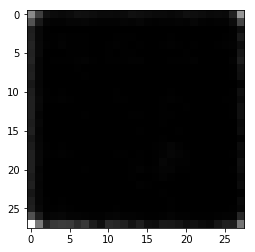

Epoch 1/2... Discriminator Loss: 0.5464... Generator Loss: 1.5095
Epoch 1/2... Discriminator Loss: 0.8818... Generator Loss: 0.8510
Epoch 1/2... Discriminator Loss: 1.1343... Generator Loss: 0.8313


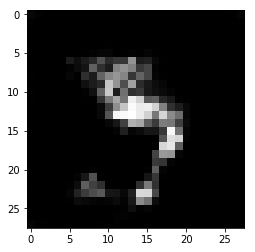

Epoch 1/2... Discriminator Loss: 0.8952... Generator Loss: 1.7499
Epoch 1/2... Discriminator Loss: 0.9477... Generator Loss: 0.8598
Epoch 1/2... Discriminator Loss: 1.0513... Generator Loss: 1.2269


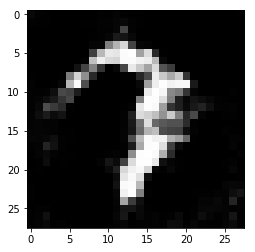

Epoch 1/2... Discriminator Loss: 1.2018... Generator Loss: 1.5303
Epoch 1/2... Discriminator Loss: 0.9024... Generator Loss: 0.9923
Epoch 1/2... Discriminator Loss: 0.9156... Generator Loss: 1.0947


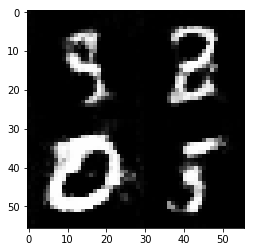

Epoch 1/2... Discriminator Loss: 1.1127... Generator Loss: 0.6514
Epoch 1/2... Discriminator Loss: 1.1816... Generator Loss: 0.6800
Epoch 1/2... Discriminator Loss: 0.9834... Generator Loss: 0.7617


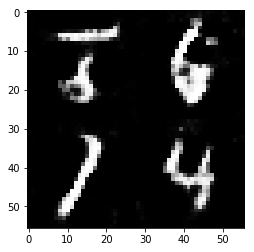

Epoch 1/2... Discriminator Loss: 1.2459... Generator Loss: 1.6790
Epoch 1/2... Discriminator Loss: 1.0526... Generator Loss: 0.6995
Epoch 1/2... Discriminator Loss: 1.0154... Generator Loss: 0.8038


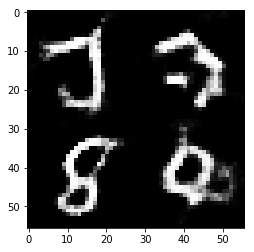

Epoch 2/2... Discriminator Loss: 1.3919... Generator Loss: 0.4076
Epoch 2/2... Discriminator Loss: 1.0297... Generator Loss: 1.4404
Epoch 2/2... Discriminator Loss: 1.4636... Generator Loss: 0.3294


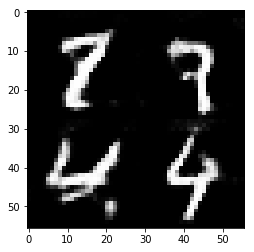

Epoch 2/2... Discriminator Loss: 1.1592... Generator Loss: 0.5870
Epoch 2/2... Discriminator Loss: 1.0264... Generator Loss: 0.7086
Epoch 2/2... Discriminator Loss: 0.9691... Generator Loss: 1.1300


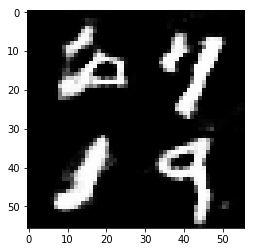

Epoch 2/2... Discriminator Loss: 0.9060... Generator Loss: 1.0118
Epoch 2/2... Discriminator Loss: 1.0663... Generator Loss: 0.6181
Epoch 2/2... Discriminator Loss: 0.9404... Generator Loss: 0.8730


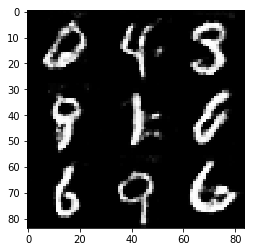

Epoch 2/2... Discriminator Loss: 1.3641... Generator Loss: 0.4269
Epoch 2/2... Discriminator Loss: 0.9660... Generator Loss: 1.2420
Epoch 2/2... Discriminator Loss: 1.1068... Generator Loss: 0.6429


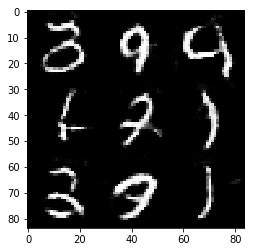

Epoch 2/2... Discriminator Loss: 1.7083... Generator Loss: 0.3220
Epoch 2/2... Discriminator Loss: 1.2544... Generator Loss: 0.4832
Epoch 2/2... Discriminator Loss: 0.9673... Generator Loss: 0.9860


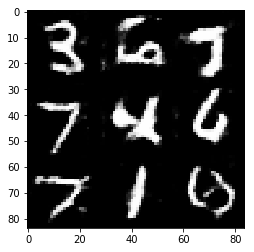

Epoch 2/2... Discriminator Loss: 0.8524... Generator Loss: 1.4889
Epoch 2/2... Discriminator Loss: 0.9502... Generator Loss: 0.7247
Epoch 2/2... Discriminator Loss: 1.0195... Generator Loss: 0.7845


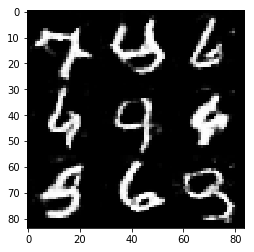

Epoch 2/2... Discriminator Loss: 1.0288... Generator Loss: 0.8962


In [193]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    losses, samples = train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.0995... Generator Loss: 3.8707
Epoch 1/1... Discriminator Loss: 0.2196... Generator Loss: 3.7664
Epoch 1/1... Discriminator Loss: 1.9846... Generator Loss: 4.7029


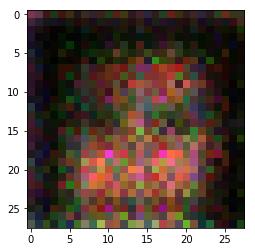

Epoch 1/1... Discriminator Loss: 0.8501... Generator Loss: 1.2202
Epoch 1/1... Discriminator Loss: 1.4580... Generator Loss: 4.6027
Epoch 1/1... Discriminator Loss: 0.8312... Generator Loss: 1.6280


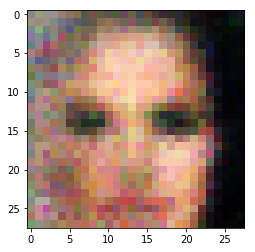

Epoch 1/1... Discriminator Loss: 1.0927... Generator Loss: 1.0399
Epoch 1/1... Discriminator Loss: 0.9543... Generator Loss: 1.2636
Epoch 1/1... Discriminator Loss: 0.7212... Generator Loss: 1.7444


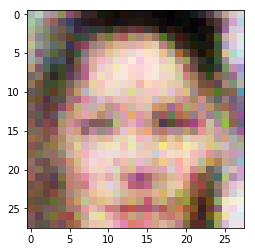

Epoch 1/1... Discriminator Loss: 1.2107... Generator Loss: 1.0501
Epoch 1/1... Discriminator Loss: 0.9177... Generator Loss: 1.4013
Epoch 1/1... Discriminator Loss: 0.8224... Generator Loss: 1.3682


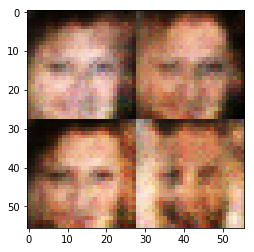

Epoch 1/1... Discriminator Loss: 1.5408... Generator Loss: 0.5485
Epoch 1/1... Discriminator Loss: 1.3160... Generator Loss: 0.4997
Epoch 1/1... Discriminator Loss: 1.5221... Generator Loss: 0.3761


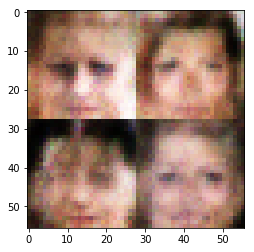

Epoch 1/1... Discriminator Loss: 1.0561... Generator Loss: 0.9695
Epoch 1/1... Discriminator Loss: 1.2638... Generator Loss: 0.5780
Epoch 1/1... Discriminator Loss: 1.0008... Generator Loss: 0.8791


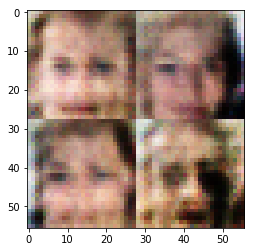

Epoch 1/1... Discriminator Loss: 1.2155... Generator Loss: 1.3430
Epoch 1/1... Discriminator Loss: 1.3015... Generator Loss: 0.5693
Epoch 1/1... Discriminator Loss: 0.9644... Generator Loss: 1.2010


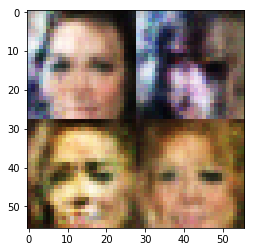

Epoch 1/1... Discriminator Loss: 1.0612... Generator Loss: 0.7843
Epoch 1/1... Discriminator Loss: 1.1577... Generator Loss: 1.2666
Epoch 1/1... Discriminator Loss: 1.0778... Generator Loss: 1.0373


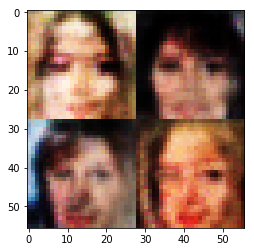

Epoch 1/1... Discriminator Loss: 1.0554... Generator Loss: 1.2401
Epoch 1/1... Discriminator Loss: 0.9989... Generator Loss: 1.6712
Epoch 1/1... Discriminator Loss: 0.9469... Generator Loss: 1.2901


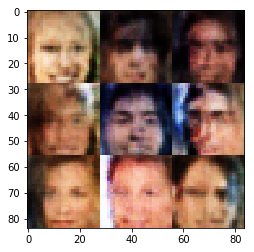

Epoch 1/1... Discriminator Loss: 1.0842... Generator Loss: 1.1067
Epoch 1/1... Discriminator Loss: 1.1204... Generator Loss: 1.1157
Epoch 1/1... Discriminator Loss: 1.1628... Generator Loss: 0.7676


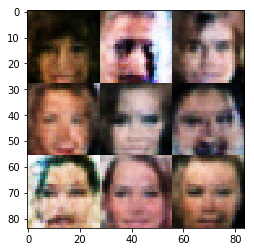

Epoch 1/1... Discriminator Loss: 1.1221... Generator Loss: 0.9100
Epoch 1/1... Discriminator Loss: 0.9800... Generator Loss: 1.1345
Epoch 1/1... Discriminator Loss: 1.1628... Generator Loss: 1.3057


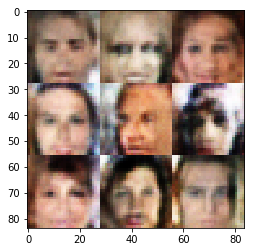

Epoch 1/1... Discriminator Loss: 1.1755... Generator Loss: 0.7578
Epoch 1/1... Discriminator Loss: 1.1583... Generator Loss: 1.2555
Epoch 1/1... Discriminator Loss: 1.1051... Generator Loss: 1.1623


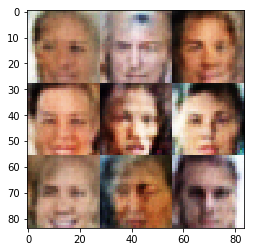

Epoch 1/1... Discriminator Loss: 1.0205... Generator Loss: 0.7322
Epoch 1/1... Discriminator Loss: 1.0797... Generator Loss: 0.8753
Epoch 1/1... Discriminator Loss: 1.3178... Generator Loss: 0.5612


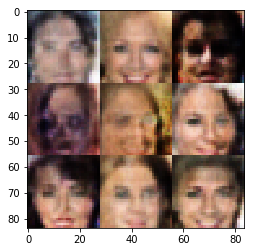

Epoch 1/1... Discriminator Loss: 1.2114... Generator Loss: 1.0701
Epoch 1/1... Discriminator Loss: 1.1243... Generator Loss: 1.0051
Epoch 1/1... Discriminator Loss: 1.1858... Generator Loss: 0.7020


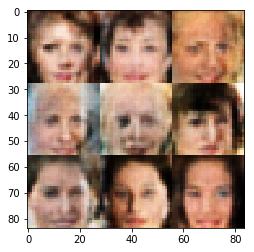

Epoch 1/1... Discriminator Loss: 1.0326... Generator Loss: 1.0495
Epoch 1/1... Discriminator Loss: 1.1104... Generator Loss: 0.6174
Epoch 1/1... Discriminator Loss: 1.1561... Generator Loss: 0.6168


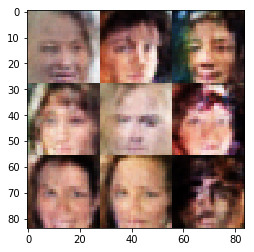

Epoch 1/1... Discriminator Loss: 1.4408... Generator Loss: 0.3581
Epoch 1/1... Discriminator Loss: 1.2482... Generator Loss: 0.8824
Epoch 1/1... Discriminator Loss: 1.0510... Generator Loss: 0.7210


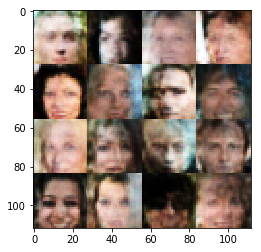

Epoch 1/1... Discriminator Loss: 1.3150... Generator Loss: 0.6398
Epoch 1/1... Discriminator Loss: 0.9738... Generator Loss: 0.8033
Epoch 1/1... Discriminator Loss: 1.3116... Generator Loss: 0.5495


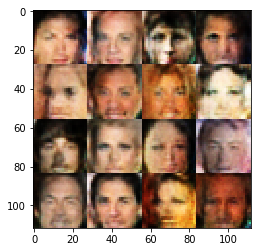

Epoch 1/1... Discriminator Loss: 0.9548... Generator Loss: 0.8222
Epoch 1/1... Discriminator Loss: 1.1095... Generator Loss: 0.8183
Epoch 1/1... Discriminator Loss: 0.9854... Generator Loss: 1.1315


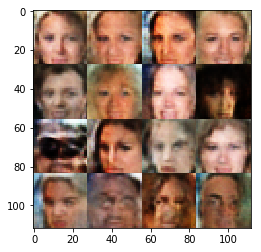

Epoch 1/1... Discriminator Loss: 0.9760... Generator Loss: 0.8325
Epoch 1/1... Discriminator Loss: 1.1342... Generator Loss: 0.6181
Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.4571


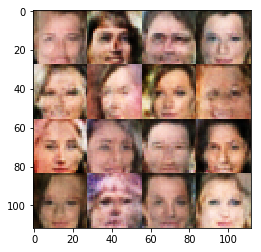

Epoch 1/1... Discriminator Loss: 1.1711... Generator Loss: 0.8650
Epoch 1/1... Discriminator Loss: 1.2128... Generator Loss: 1.2639
Epoch 1/1... Discriminator Loss: 1.1290... Generator Loss: 0.8143


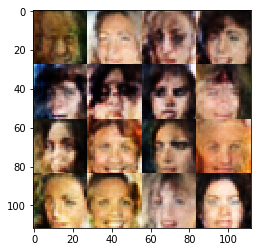

Epoch 1/1... Discriminator Loss: 1.2124... Generator Loss: 0.5951
Epoch 1/1... Discriminator Loss: 1.0897... Generator Loss: 0.7781
Epoch 1/1... Discriminator Loss: 1.1195... Generator Loss: 0.7687


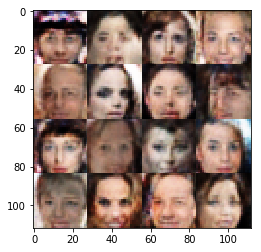

In [194]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.